In [22]:
import collections
import matplotlib.pyplot as plt
from collections import defaultdict
import collections
import numpy as np
from statistics import mean 
import time
from scipy import stats
import networkx as nx
from sklearn import preprocessing

In [2]:
"""Benchmark dataset reader."""
ts = time.time()
from littleballoffur.data_reader import GraphReader

reader = GraphReader('bitcoinalpha')

graph = reader.get_graph()
time.time() - ts

2.2925050258636475

In [3]:
nx.is_weighted(graph)

True

In [4]:
ts = time.time()
#Random walk

from littleballoffur.exploration_sampling import SpikyBallSampler

sampler = SpikyBallSampler(number_of_nodes= 1000,mode = "hubball")

spiky_graph = sampler.sample(graph)

print('original graph nodes', len(graph.nodes))
print('after sampling graph nodes', len(spiky_graph.nodes))
time.time() - ts

New nodes 639
P_ norm (639,)
New nodes 4331
P_ norm (4331,)
New nodes 4227
P_ norm (4227,)
original graph nodes 3783
after sampling graph nodes 1000


10.32407259941101

In [6]:
nx.is_weighted(spiky_graph)

True

In [9]:
ts = time.time()
#Original graph
print('Average Clustering - Original: ',nx.average_clustering(graph))

print('-------------------------------------------------------------------')
#Spiky Ball
print('Average Clustering - Spiky ball: ',nx.average_clustering(spiky_graph))
time.time() - ts


Average Clustering - Original:  0.1766290303590772
-------------------------------------------------------------------
Average Clustering - Spiky ball:  0.2998100687889353


1.4079947471618652

In [11]:
ts = time.time()
#Original graph
print('Triangles Percentage - Original: ',(sum(nx.triangles(graph).values()) / 3)/len(graph.nodes))

print('-------------------------------------------------------------------')
#Spiky Ball
print('Triangles Percentage- Spiky Ball: ',(sum(nx.triangles(spiky_graph).values()) / 3)/len(spiky_graph.nodes))

time.time() - ts



Triangles Percentage - Original:  5.855934443563309
-------------------------------------------------------------------
Triangles Percentage- Spiky Ball:  17.401


1.2669861316680908

In [12]:
ts = time.time()
#Original graph
print('Size of largest connected component - Original: ',len(max(nx.connected_components(graph))))

print('-------------------------------------------------------------------')
#Spiky Ball
print('Size of largest connected component- Spiky Ball: ',len(max(nx.connected_components(spiky_graph))))


time.time() - ts


Size of largest connected component - Original:  3775
-------------------------------------------------------------------
Size of largest connected component- Spiky Ball:  994


0.052999258041381836

In [13]:
ts = time.time()
#Original graph
print('Degree Assortativity Coefficient - Original: ',nx.degree_assortativity_coefficient(graph))

print('-------------------------------------------------------------------')

#Spiky Ball
print('Degree Assortativity Coefficient - Spiky Ball: ',nx.degree_assortativity_coefficient(spiky_graph))

time.time() - ts



Degree Assortativity Coefficient - Original:  -0.16851576112150454
-------------------------------------------------------------------
Degree Assortativity Coefficient - Spiky Ball:  -0.21938044409243337


1.5009913444519043

In [14]:
def degree_distributon(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    return deg,cnt

In [15]:
ts = time.time()
#Original 
deg,cnt = degree_distributon(graph)

#Random Walk
deg1,cnt1 = degree_distributon(spiky_graph)

time.time() - ts

0.03499889373779297

Text(0.5, 0, 'Degree')

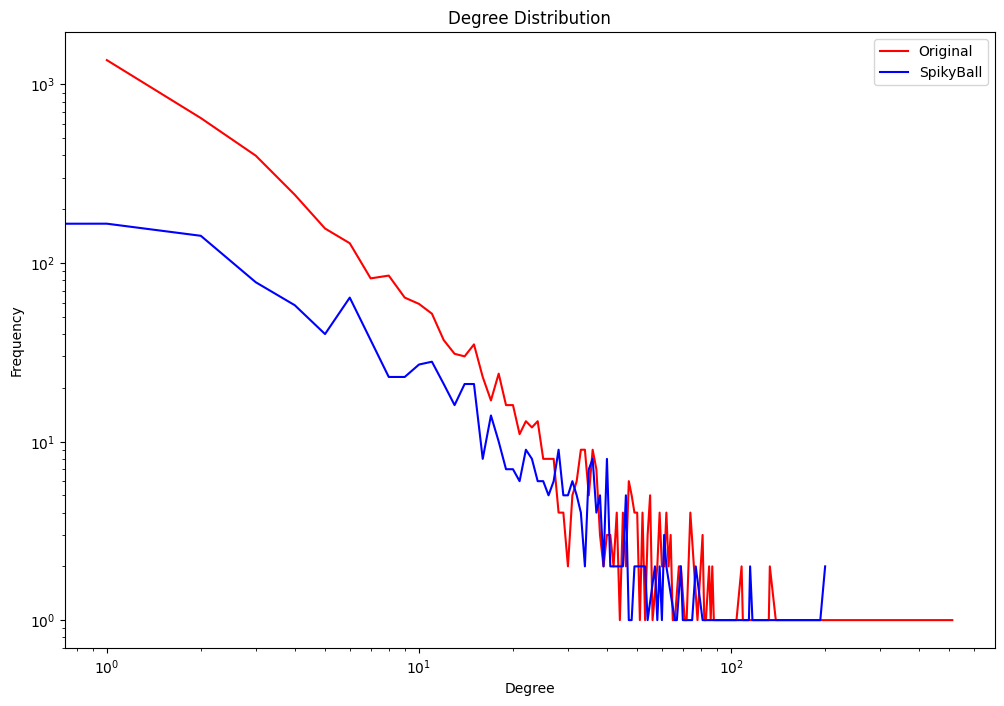

In [17]:
plt.figure(figsize=(12, 8))
plt.loglog(deg, cnt, 'r-', label='original')
plt.loglog(deg1,cnt1, 'b-', label='SpikyBall')

plt.legend(['Original','SpikyBall','FF/SNOW','SP'])
plt.title("Degree Distribution")
plt.ylabel("Frequency")
plt.yscale('log')
# plt.xscale('log')
plt.xlabel("Degree")

In [18]:
# def degree_clustering(G):
#    degree = G.degree()
#    degree_list,degrees,clustering_list = [],[],[]
#    for n,m in degree:
#       degree_list.append(m)
#    degree_list
#    degree_np = np.asarray(sorted(degree_list))
  

#    for k in range(len(np.unique(degree_np))):
#       nodes_degree_k = ([u for u in G.nodes() if G.degree(u) == k])
#       if len(nodes_degree_k) != 0:
#          clustering_coeff = nx.average_clustering(G, nodes_degree_k)
#          degrees.append(k)
#          clustering_list.append(clustering_coeff)
#       nodes_degree_k = []
         
#    return degrees,clustering_list 


def degree_clustering(original, sample):
   degree = sample.degree()
   degree_list,degrees,clustering_list,kstest = [],[],[],[]
   
   for n,m in degree:
      degree_list.append(m)
   degree_list
   degree_np = np.asarray(sorted(degree_list))
  

   for k in range(len(np.unique(degree_np))):
      sample_nodes_degree_k = ([u for u in sample.nodes() if sample.degree(u) == k])
      if len(sample_nodes_degree_k) != 0:
        sample_clustering_coef = nx.clustering(sample, sample_nodes_degree_k)
        original_nodes_degree_k = ([u for u in original.nodes() if original.degree(u) == k])
        original_clustering_coef = nx.clustering(original, original_nodes_degree_k)
        avg_clustering_coeff = nx.average_clustering(sample, sample_nodes_degree_k)

        original_clustering_coef = np.fromiter(original_clustering_coef.values(), dtype=float)
        
        sample_clustering_coef = np.fromiter(sample_clustering_coef.values(), dtype=float)
        
        if len(original_clustering_coef) != 0:
         if len(sample_clustering_coef) != 0:
            ks_test = stats.ks_2samp(preprocessing.scale(original_clustering_coef), preprocessing.scale(sample_clustering_coef))[0]

            kstest.append(ks_test)
        degrees.append(k)
        clustering_list.append(avg_clustering_coeff)
      nodes_degree_k = []
    
   avg_kstest = np.average(kstest)
         
   return degrees,clustering_list,avg_kstest 

In [23]:
ts = time.time()
degrees,clustering_list,avg_kstest = degree_clustering(graph,graph)
degrees1,clustering_list1,avg_kstest1 = degree_clustering(graph,spiky_graph)

time.time() - ts

10.22699785232544

Text(0.5, 0, 'Node Degree')

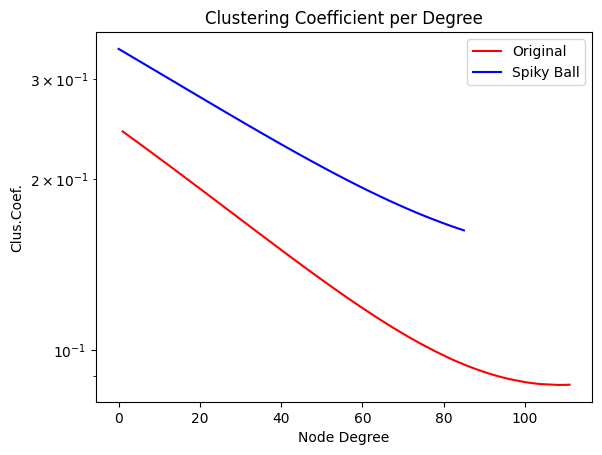

In [26]:
z = np.polyfit(degrees, clustering_list,2)
p = np.poly1d(z)
plt.plot(degrees,p(degrees),"red")

z = np.polyfit(degrees1, clustering_list1,2)
p = np.poly1d(z)
plt.plot(degrees1,p(degrees1),"blue")



plt.legend(['Original','Spiky Ball','FF/SNOW','SP'])
plt.title("Clustering Coefficient per Degree")
plt.ylabel("Clus.Coef.")
# plt.xscale('log')
plt.yscale('log')
plt.xlabel("Node Degree")